# Notebook to train a model only on specific layers to evaluate the amound of ink in there indirectly on the performance!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import os
from glob import glob
import pickle
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchmetrics
from pytorch_lightning.loggers import TensorBoardLogger
from monai import losses
import albumentations as A
from copy import deepcopy
from pytorch_lightning.callbacks import Callback
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import WeightedRandomSampler
import random
import segmentation_models_pytorch as smp
import gc

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
# paths and hyperparameters
name = '2DCNN_Check_Ink_Depth'
folder = '/home/olli/Projects/Kaggle/Vesuvius'
folder_logs = os.path.join(folder, f'Logs_2D')
depth = 13
size = 1024
batch_size = 8
num_workers = 16
epochs = 14
learning_rate = 2e-4  # max lr to reach
pct_increase = 0.33  # percentage of epochs to increase the lr before decreasing
bce_loss_weight = 0.5  # how much to weight dice vs bce (0.5-0.5; 0.7-0.3; ...)
ink_loss_weight = 2

# Define Augmentations

In [4]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.82),
    A.ShiftScaleRotate(p=0.47),
    A.OneOf([
            A.GaussNoise(var_limit=[10, 50]),
            A.GaussianBlur(),
            A.MotionBlur(),
            ], p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.32),
    A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.47),
    A.Normalize(mean=[0] * depth, std=[1] * depth)
])

In [5]:
# use valid aug to normalize the scan
valid_aug = A.Compose([
    A.Normalize(mean=[0] * depth, std=[1] * depth)
])

# Define the PyTorch Dataset

In [6]:
class Data(Dataset):
    def __init__(self, paths, transform=False):#, df=df):
        self.paths = paths
        self.transform = transform
        #self.df = df
        
        random.Random(42).shuffle(self.paths)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        
        with open(path, 'rb') as f:
            data = pickle.load(f)
            
        X, mask, y = data
        
        if self.transform:
            augmented_data = self.transform(image=X, masks=[mask, y])
            
            X = augmented_data['image']
            mask = augmented_data['masks'][0]
            y = augmented_data['masks'][1]
        
        mask = torch.tensor(mask / 255.).type(torch.float32)
        y = torch.tensor(y / 255.).type(torch.float32)
        
        X = torch.tensor(X).permute(2, 0, 1).type(torch.float32)
        
        return X, mask, y

# Create a Lightning Data Module from that

In [7]:
# create a lightning datamodule class

class DataModule(pl.LightningDataModule):
    
    def __init__(self, train_ds, valid_ds, batch_size=batch_size, num_workers=num_workers):
        
        super().__init__()

        self.batch_size=batch_size
        self.num_workers=num_workers
        
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        
    def setup(self, stage):
        
        self.train_ds = self.train_ds
        self.valid_ds = self.valid_ds
        
        # set up the sampler with the shuffled training paths
        #files = [path.split('.')[-2].split('/')[-1] for path in self.train_ds.paths]
        #scans = [path.split('.')[-2].split('/')[-3] for path in self.train_ds.paths]
        #filenames = [scan + '_' + file for scan, file in zip(scans, files)]
        
        # sort the df to only have these with filenames in Index col
        #df_filtered = self.train_ds.df[self.train_ds.df['Index'].isin(filenames)]
        
        # now sort the df_filtered exactly how the filesnames are sorted
        #df_sorted = df_filtered.iloc[np.argsort([filenames.index(i) for i in df_filtered['Index']])]
        
        # now get the weights that are ordered correctly
        #self.weights = df_sorted['Weight'].values
        
    def train_dataloader(self):
        
        train_dl = DataLoader(self.train_ds,
                              batch_size=self.batch_size,
                              num_workers=self.num_workers,
                              shuffle=True)
                              #pin_memory=True)
        
        return train_dl
        
    def val_dataloader(self):
        
        valid_dl = DataLoader(self.valid_ds,
                              batch_size=self.batch_size,
                              num_workers=self.num_workers,)
                              #pin_memory=True)
        
        return valid_dl

# Define the model

In [8]:
model = smp.Unet('se_resnext50_32x4d', encoder_weights=None, in_channels=depth, classes=1)

In [9]:
# save the initial model weights to use them for each fold
random_weights_path = f'{folder}/Weights/{name}_random.pth'
if not os.path.exists(random_weights_path):
    torch.save(model.state_dict(), random_weights_path)

# Create a custom metric for the dice F 0.5 score

In [10]:
class CustomDice(torchmetrics.Metric):
    def __init__(self, beta=0.5, smooth=1e-5):
        super().__init__()
        
        self.beta = beta
        self.smooth = smooth
        self.add_state("ctp", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("cfp", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("y_true_count", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, apply_sigmoid=True):
        
        if apply_sigmoid:
            preds = torch.sigmoid(preds)
        preds = preds.view(-1)#.float()
        target = target.view(-1)#.float()

        self.y_true_count += target.sum()
        self.ctp += preds[target == 1].sum()
        self.cfp += preds[target == 0].sum()

    def compute(self):
        c_precision = self.ctp / (self.ctp + self.cfp + self.smooth)
        c_recall = self.ctp / (self.y_true_count + self.smooth)
        beta_squared = self.beta * self.beta
        dice_score = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + self.smooth)

        return dice_score

# Create the Lightning Module

In [11]:
class NN(pl.LightningModule):
    def __init__(self, 
                 model, 
                 learning_rate,
                 overweight_ink=ink_loss_weight,
                 bce_loss_weight=bce_loss_weight,
                 calculate_threshold=False):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.dice = CustomDice()
        self.calc_th = calculate_threshold
        self.overweight_ink = ink_loss_weight
        self.bce_loss_weight = bce_loss_weight
        self.epochs = epochs
        self.pct_increase = pct_increase
        self.BCE = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.overweight_ink))
        
        self.dice_loss = losses.DiceLoss(sigmoid=True)
        #self.masked_dice = losses.MaskedDiceLoss(sigmoid=True)
        self.bce = nn.functional.binary_cross_entropy_with_logits
        
        self.predictions = []  # for holding both to calculate the optimal thresholds
        self.targets = []
        
        self.best_score = torch.tensor(0)
        
    def forward(self, x):
        x = self.model(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        X, mask, y = batch
        
        pred = self.model(X)
        
        # add class dim
        mask = mask.unsqueeze(1)
        y = y.unsqueeze(1)
        
        dice_loss = self.dice_loss(pred, y)
        
        bce_loss = self.BCE(pred, y)
        
        #dice_loss = self.masked_dice(pred, target=y, mask=mask)
                
        #bce_loss = self.bce(pred, y, weight=mask)
        
        # now calculate the final loss on the defined ration (diceloss vs bceloss)
        loss = self.bce_loss_weight * bce_loss + (1 - self.bce_loss_weight) * dice_loss
        
        #loss = self.BCE(pred, y)
        
        with torch.no_grad():
            dice_score = self.dice(pred, y)
            
        self.log_dict({'train_loss': loss,
                       'train_dice': dice_score},
                       on_step=False,
                       on_epoch=True,
                       prog_bar=True,
                       logger=True)
        
        return {'loss': loss, 'train_dice': dice_score}
        
    def validation_step(self, batch, batch_idx):
        X, mask, y = batch
        
        with torch.no_grad():
            pred = self.model(X)
        
        # append the pred and y for thresholding
        self.predictions.append(pred.flatten()) # flatten them for calculation
        self.targets.append(y.flatten())
        
        # add class dim
        mask = mask.unsqueeze(1)
        y = y.unsqueeze(1)
        
        dice_loss = self.dice_loss(pred, y)
        
        bce_loss = self.BCE(pred, y)
        
        #dice_loss = self.masked_dice(pred, target=y, mask=mask)
                
        #bce_loss = self.bce(pred, y, weight=mask)
        
        # now calculate the final loss on the defined ration (diceloss vs bceloss)
        loss = self.bce_loss_weight * bce_loss + (1 - self.bce_loss_weight) * dice_loss
        
        #loss = self.BCE(pred, y)
        
        dice_score = self.dice(pred, y)
        
        self.log_dict({'valid_loss': loss,
                       'valid_dice': dice_score},
                        on_step=False,
                        on_epoch=True,
                        prog_bar=True,
                        logger=True)
        
        return {'valid_loss': loss, 'valid_dice': dice_score}
    
    def on_validation_epoch_end(self):
        #if self.calc_th:  # dont calculate the optimal threshold when tuning hp
            thresholds = np.arange(start=0.2, stop=0.8, step=0.05)  # thresholds to try
            scores = []  # append the scores here to log them after all done
            # use the attributes to calculate the dice score for each threshold
            predictions = torch.cat(self.predictions, dim=0)
            targets = torch.cat(self.targets, dim=0)

            # first apply sigmoid to apply correct threshold
            predictions = torch.sigmoid(predictions)

            # try all thresholds
            for threshold in thresholds:
                threshold = torch.tensor(threshold)

                # make predictions binary based on threshold            
                pred_th = torch.where(predictions > threshold, 1, 0)

                dice_score = self.dice(pred_th, targets, apply_sigmoid=False).cpu()
                print('TH: ', threshold, ' - Dice: ', dice_score)
                scores.append(dice_score)

            # get the index of the best dice score
            index_best = torch.argmax(torch.tensor(scores))

            best_dice = torch.round(scores[index_best].clone(), decimals=3)
            best_threshold = thresholds[index_best]
            
            if best_dice > self.best_score:
                self.best_score = best_dice

            print(f'Best Threshold: {best_threshold} - Best Dice Score: {best_dice}')

            # Log the best dice valid        
            self.log_dict({'Best_Threshold': torch.tensor(best_threshold), 'Best_Dice': best_dice},
                           on_step=False, on_epoch=True, prog_bar=True, logger=True)

            # reset after each epoch
            self.predictions = []
            self.targets = []
        
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # needs params: total steps or steps per epoch and epochs
        total_steps = len(self.trainer.datamodule.train_dataloader()) * self.epochs
        scheduler = OneCycleLR(optimizer=optim,
                               max_lr=self.learning_rate,
                               epochs=self.epochs,
                               #steps_per_epoch=10,
                               total_steps = total_steps, #epochs*10,
                               pct_start=self.pct_increase,)
                               #verbose=True)
        return [optim], [{"scheduler": scheduler, "interval": "step"}]

# Use Fragments 2 and 3 and evaluate the model on Fragment 1

In [12]:
%%time

df = pd.DataFrame({'Depths': [], 'F0.5-Score': []})

folder_data = os.path.join(folder, 'Data_New')
start_depths = [0, 13, 26, 39, 52]
end_depths = [12, 25, 38, 51, 64]
for start, end in zip(start_depths, end_depths):
    path_files = os.path.join(folder_data, f'Preprocessed_{size}_{start}_{end}')
    scan_1_folder = os.path.join(path_files, '1', '1024')
    scan_2_folder = os.path.join(path_files, '2', '1024')
    scan_3_folder = os.path.join(path_files, '3', '1024')
    files_scan_1 = glob(scan_1_folder + '/*pickle')
    files_scan_2 = glob(scan_2_folder + '/*pickle')
    files_scan_3 = glob(scan_3_folder + '/*pickle')
    train_files = files_scan_2 + files_scan_3
    valid_files = files_scan_1
    MODEL = NN(model=model, learning_rate=learning_rate, calculate_threshold=True)
    MODEL.model.load_state_dict(torch.load(random_weights_path))
    train_ds = Data(paths=train_files, transform=train_aug)
    valid_ds = Data(paths=valid_files, transform=valid_aug)
    dm = DataModule(train_ds=train_ds, valid_ds=valid_ds)
    trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=epochs, precision='16-mixed')
    trainer.fit(MODEL, dm)
    score = MODEL.best_score.detach().cpu().numpy()
    new_df = pd.DataFrame({'Depths': [f'{start}:{end}'], 'F0.5-Score': [score]})
    df = pd.concat([df, new_df])
    print(f'Depth from {start} - {end} performance: {score} [F0.5-Score]')
    gc.collect()
    torch.cuda.empty_cache()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 34.6 M
1 | dice      | CustomDice        | 0     
2 | BCE       | BCEWithLogitsLoss | 0     
3 | dice_loss | DiceLoss          | 0     
------------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
138.221   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2281)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0007)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.2280000001192093


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2586)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2609)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2621)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2628)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2630)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2627)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2610)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2569)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2468)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2238)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1762)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1051)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0440)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.2630000114440918


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2512)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2540)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2577)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2588)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2578)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2548)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2473)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2275)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.1821)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.1113)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0504)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0205)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0089)
Best Threshold: 0.35 - Best Dice Score: 0.2590000033378601


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2639)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2651)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2655)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2647)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2601)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2426)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.1748)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0539)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0079)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0012)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(4.1834e-05)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(8.9478e-06)
Best Threshold: 0.3 - Best Dice Score: 0.26600000262260437


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2655)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2651)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2631)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2581)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2457)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2019)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0852)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0352)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0204)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0122)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0071)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0038)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0018)
Best Threshold: 0.2 - Best Dice Score: 0.26600000262260437


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2636)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2670)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2671)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2643)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2468)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1201)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0115)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0008)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(6.1413e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(1.2086e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.2669999897480011


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2535)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2546)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2557)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2569)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2489)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1309)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0798)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0655)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0549)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0457)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0374)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0299)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0231)
Best Threshold: 0.35 - Best Dice Score: 0.25699999928474426


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2525)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2588)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2604)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2572)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2126)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0923)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0536)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0360)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0254)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0182)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0131)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0093)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0064)
Best Threshold: 0.3 - Best Dice Score: 0.25999999046325684


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2581)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2635)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2657)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2631)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2004)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0247)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0041)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0015)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0007)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0004)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0001)
Best Threshold: 0.3 - Best Dice Score: 0.26600000262260437


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2501)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2497)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2488)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2446)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2107)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0323)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0043)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0011)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0004)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(7.9545e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(3.8933e-05)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(1.5477e-05)
Best Threshold: 0.2 - Best Dice Score: 0.25


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2688)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2687)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2682)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2609)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1765)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0228)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0073)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0046)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0034)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0026)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0020)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0015)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0011)
Best Threshold: 0.2 - Best Dice Score: 0.26899999380111694


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2663)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2665)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2663)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2606)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1823)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0136)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0008)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(9.2839e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(2.2005e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(5.3199e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.6926e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.25 - Best Dice Score: 0.2669999897480011


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2645)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2647)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2639)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2593)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1969)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0196)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0012)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(3.2395e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(4.3496e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.25 - Best Dice Score: 0.26499998569488525


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2661)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2658)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2647)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2590)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1863)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0187)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0016)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(5.9230e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(1.9343e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(9.4305e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(2.9014e-06)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(9.6702e-07)
Best Threshold: 0.2 - Best Dice Score: 0.26600000262260437


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2672)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2676)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2666)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2616)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1964)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0192)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0014)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(6.7214e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(3.0711e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.4026e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(7.7388e-06)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(2.4183e-06)
Best Threshold: 0.25 - Best Dice Score: 0.2680000066757202


`Trainer.fit` stopped: `max_epochs=14` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 34.6 M
1 | dice      | CustomDice        | 0     
2 | BCE       | BCEWithLogitsLoss | 0     
3 | dice_loss | DiceLoss          | 0     
------------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
138.221   Total estimated model params size (MB)


Depth from 0 - 12 performance: 0.26899999380111694 [F0.5-Score]


Sanity Checking: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2269)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0004)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.22699999809265137


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2591)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2616)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2629)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2635)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2636)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2628)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2606)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2555)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2440)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2211)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1776)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1135)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0533)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.2639999985694885


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2611)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2630)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2643)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2647)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2641)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2617)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2544)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2337)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.1849)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.1073)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0426)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0136)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0041)
Best Threshold: 0.35 - Best Dice Score: 0.26499998569488525


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2412)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2419)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2408)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2372)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2290)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2110)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.1734)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.1146)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0607)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0321)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0197)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0141)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0109)
Best Threshold: 0.25 - Best Dice Score: 0.24199999868869781


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2636)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2650)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2661)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2674)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2691)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2703)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2692)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2562)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.1768)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0353)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0039)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0020)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0011)
Best Threshold: 0.44999999999999996 - Best Dice Score: 0.27000001072883606


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2670)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2681)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2694)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2727)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2800)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2819)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2486)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.1358)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0145)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(6.2384e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.44999999999999996 - Best Dice Score: 0.28200000524520874


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2654)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2667)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2680)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2696)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2713)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2498)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.1024)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0066)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(4.7385e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(4.8234e-07)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.2709999978542328


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2546)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2550)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2561)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2579)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2629)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2636)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2634)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2622)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2572)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2317)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1673)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0746)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0186)
Best Threshold: 0.44999999999999996 - Best Dice Score: 0.2639999985694885


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2645)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2654)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2660)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2669)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2674)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2675)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2671)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2661)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2659)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2695)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2699)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.2307)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.1405)
Best Threshold: 0.7 - Best Dice Score: 0.27000001072883606


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2724)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2773)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2826)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2859)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2864)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2856)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2836)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2807)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2691)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2454)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2109)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1592)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0910)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.28600001335144043


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2674)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2695)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2715)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2449)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1771)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1296)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.1006)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0802)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0588)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0391)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0268)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0183)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0116)
Best Threshold: 0.3 - Best Dice Score: 0.2720000147819519


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2750)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2773)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2788)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2798)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2809)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2818)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2830)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2840)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2845)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2841)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2794)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.2650)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.2367)
Best Threshold: 0.5999999999999999 - Best Dice Score: 0.2840000092983246


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2731)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2766)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2789)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2817)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2844)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2885)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2948)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2962)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2879)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2665)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2278)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1754)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.1177)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.29600000381469727


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2736)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2784)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2846)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2921)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.3001)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.3085)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.3158)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.3133)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2994)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2740)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2347)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1904)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.1402)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.3160000145435333


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2744)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2786)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2837)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2901)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2972)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.3053)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.3142)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.3153)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.3027)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2788)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2373)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1898)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.1384)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.3149999976158142


`Trainer.fit` stopped: `max_epochs=14` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 34.6 M
1 | dice      | CustomDice        | 0     
2 | BCE       | BCEWithLogitsLoss | 0     
3 | dice_loss | DiceLoss          | 0     
------------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
138.221   Total estimated model params size (MB)


Depth from 13 - 25 performance: 0.3160000145435333 [F0.5-Score]


Sanity Checking: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2286)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.2290000021457672


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2527)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2541)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2566)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2606)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2644)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2668)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2666)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2612)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2410)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.1919)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1142)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0494)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0184)
Best Threshold: 0.44999999999999996 - Best Dice Score: 0.2669999897480011


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2535)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2555)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2587)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2623)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2668)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2726)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2790)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2823)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2723)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2321)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1568)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0809)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0350)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.28200000524520874


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2517)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2536)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2562)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2574)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2584)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2622)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2698)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2632)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.1908)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0696)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0163)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0046)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0012)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.27000001072883606


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2537)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2543)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2555)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2571)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2583)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2594)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2602)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2609)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2616)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.2627)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.2643)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.2662)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.2685)
Best Threshold: 0.7999999999999998 - Best Dice Score: 0.26899999380111694


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2955)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.3113)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.3233)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.3327)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.3408)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.3492)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.3626)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.3795)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4023)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4262)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4381)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4300)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4034)
Best Threshold: 0.7 - Best Dice Score: 0.43799999356269836


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3148)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.3327)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.3491)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.3642)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.3758)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.3853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.3962)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4066)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4129)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4100)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.3942)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.3604)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.3073)
Best Threshold: 0.5999999999999999 - Best Dice Score: 0.4129999876022339


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3594)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.3741)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.3837)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.3914)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.3969)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4023)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4072)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4091)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4069)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4026)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.3932)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.3766)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.3532)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.4090000092983246


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3215)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.3432)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.3463)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.3373)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.3245)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.3021)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2760)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2437)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.2112)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.1832)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.1570)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.1309)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.1013)
Best Threshold: 0.3 - Best Dice Score: 0.34599998593330383


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3940)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4069)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4161)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4227)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4270)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4302)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4323)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4328)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4309)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4275)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4212)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4089)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.3862)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.43299999833106995


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3867)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4081)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4257)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4389)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4482)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4600)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4687)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4752)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4783)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4758)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4663)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4444)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4020)
Best Threshold: 0.5999999999999999 - Best Dice Score: 0.4779999852180481


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.3937)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4111)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4274)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4406)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4504)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4622)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4713)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4789)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4825)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4816)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4746)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4590)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4264)
Best Threshold: 0.5999999999999999 - Best Dice Score: 0.4819999933242798


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.4173)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4351)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4480)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4567)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4629)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4693)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4728)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4739)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4729)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4694)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4611)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4437)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4110)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.4740000069141388


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.4340)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4505)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4632)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4717)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4774)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4826)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4852)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4855)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4826)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4767)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4675)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4529)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4277)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.48500001430511475


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.4221)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.4398)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.4538)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.4633)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.4706)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.4777)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.4824)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.4846)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.4840)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.4816)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.4751)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.4625)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.4397)
Best Threshold: 0.5499999999999999 - Best Dice Score: 0.48500001430511475


`Trainer.fit` stopped: `max_epochs=14` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 34.6 M
1 | dice      | CustomDice        | 0     
2 | BCE       | BCEWithLogitsLoss | 0     
3 | dice_loss | DiceLoss          | 0     
------------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
138.221   Total estimated model params size (MB)


Depth from 26 - 38 performance: 0.48500001430511475 [F0.5-Score]


Sanity Checking: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2310)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.9359e-06)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.23100000619888306


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2531)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2535)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2537)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2538)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2531)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2499)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2408)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2074)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0984)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0163)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0033)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0013)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0007)
Best Threshold: 0.35 - Best Dice Score: 0.2540000081062317


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2534)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2537)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2540)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2542)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2536)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2500)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2356)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.1766)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0611)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0125)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0057)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0041)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0034)
Best Threshold: 0.35 - Best Dice Score: 0.2540000081062317


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2542)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2544)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2547)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2516)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2218)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1057)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0269)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0129)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0101)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0090)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0082)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0075)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0068)
Best Threshold: 0.3 - Best Dice Score: 0.2549999952316284


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2546)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2548)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2550)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2402)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1493)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0417)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0088)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0030)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0016)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0009)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(5.8758e-05)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(9.4313e-06)
Best Threshold: 0.3 - Best Dice Score: 0.2549999952316284


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2548)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2550)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2553)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2409)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1019)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0111)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0014)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(1.9590e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(1.9349e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.2549999952316284


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2547)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2549)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2551)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2565)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2481)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1520)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0189)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0027)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0005)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(3.3589e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.9315e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.35 - Best Dice Score: 0.25699999928474426


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2552)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2555)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2560)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2078)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0843)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0608)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0406)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0262)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0143)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0049)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0012)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0001)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(6.0442e-06)
Best Threshold: 0.3 - Best Dice Score: 0.25600001215934753


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2552)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2567)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2609)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1755)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0452)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0236)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0107)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0039)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0014)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.2109e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.26100000739097595


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2650)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2672)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2647)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2204)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0286)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0066)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0009)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.1941e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(4.3846e-07)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.25 - Best Dice Score: 0.2669999897480011


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2607)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2631)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2648)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2671)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1518)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0883)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0218)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0091)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0042)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0013)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(4.6639e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(2.1758e-06)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.35 - Best Dice Score: 0.2669999897480011


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2639)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2649)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2661)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2605)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1800)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1210)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0620)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0417)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0210)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0122)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0070)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0027)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0008)
Best Threshold: 0.3 - Best Dice Score: 0.26600000262260437


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2660)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2676)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2692)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2644)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1441)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0417)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0148)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0090)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0062)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0026)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0012)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(5.2654e-06)
Best Threshold: 0.3 - Best Dice Score: 0.26899999380111694


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2674)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2687)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2704)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2750)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1179)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0715)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0440)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0313)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0213)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0122)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0079)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0046)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0027)
Best Threshold: 0.35 - Best Dice Score: 0.2750000059604645


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2670)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2683)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2697)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2711)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1539)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0790)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0482)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0326)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0227)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0124)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0078)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0044)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0027)
Best Threshold: 0.35 - Best Dice Score: 0.2709999978542328


`Trainer.fit` stopped: `max_epochs=14` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Unet              | 34.6 M
1 | dice      | CustomDice        | 0     
2 | BCE       | BCEWithLogitsLoss | 0     
3 | dice_loss | DiceLoss          | 0     
------------------------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
138.221   Total estimated model params size (MB)


Depth from 39 - 51 performance: 0.2750000059604645 [F0.5-Score]


Sanity Checking: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1853)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2311)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.49999999999999994 - Best Dice Score: 0.23100000619888306


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2318)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2521)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2533)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2538)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2541)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2538)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2493)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.2110)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0564)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0024)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0001)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(9.2224e-05)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.2540000081062317


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2547)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2552)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2556)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2560)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2565)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2560)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.2475)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.1824)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0854)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0328)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0052)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0005)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.0001)
Best Threshold: 0.39999999999999997 - Best Dice Score: 0.25600001215934753


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2544)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2547)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2552)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2556)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2551)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.2442)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.1678)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0105)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0010)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0005)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(9.6291e-05)
Best Threshold: 0.35 - Best Dice Score: 0.25600001215934753


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2554)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2565)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2574)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2570)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.2411)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.1143)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0085)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0006)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0001)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(4.8283e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.2310e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(9.6001e-07)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.25699999928474426


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2554)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2560)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2567)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2552)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0905)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0231)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0010)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(8.3234e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(1.1818e-05)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(2.1656e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(2.3857e-07)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.25699999928474426


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2561)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2571)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2583)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2563)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0817)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0058)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0011)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0007)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0004)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(7.9558e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(2.8205e-05)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(1.0845e-05)
Best Threshold: 0.3 - Best Dice Score: 0.257999986410141


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2581)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2620)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2654)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2498)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0149)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0031)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(0.0005)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(7.5884e-05)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(2.6000e-05)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(5.2710e-06)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(2.3959e-06)
Best Threshold: 0.3 - Best Dice Score: 0.26499998569488525


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2624)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2658)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2676)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2681)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0257)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0079)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(2.2938e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(4.8282e-06)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(2.6582e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.35 - Best Dice Score: 0.2680000066757202


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2663)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2675)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2685)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2701)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0604)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0020)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(1.3057e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(3.1439e-06)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(2.9023e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(1.9349e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(4.8372e-07)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.35 - Best Dice Score: 0.27000001072883606


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2626)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2656)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2680)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2686)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.1261)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0004)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(1.3781e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.35 - Best Dice Score: 0.26899999380111694


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2691)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2701)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2706)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2699)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0246)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(5.6680e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.6300e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(4.5265e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(3.5896e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(2.1568e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(0.)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(0.)
Best Threshold: 0.3 - Best Dice Score: 0.2709999978542328


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2689)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2700)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2707)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2595)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0197)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0003)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(4.8744e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.6652e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(9.4168e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(4.5882e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.4480e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(7.2411e-07)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(2.4151e-07)
Best Threshold: 0.3 - Best Dice Score: 0.2709999978542328


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2713)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2718)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2720)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2632)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0216)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(4.2502e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.9327e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(9.9069e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(4.5911e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(2.1750e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(1.4506e-06)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(7.2543e-07)
Best Threshold: 0.3 - Best Dice Score: 0.2720000147819519


Validation: 0it [00:00, ?it/s]

TH:  tensor(0.2000, dtype=torch.float64)  - Dice:  tensor(0.2715)
TH:  tensor(0.2500, dtype=torch.float64)  - Dice:  tensor(0.2719)
TH:  tensor(0.3000, dtype=torch.float64)  - Dice:  tensor(0.2722)
TH:  tensor(0.3500, dtype=torch.float64)  - Dice:  tensor(0.2653)
TH:  tensor(0.4000, dtype=torch.float64)  - Dice:  tensor(0.0189)
TH:  tensor(0.4500, dtype=torch.float64)  - Dice:  tensor(0.0002)
TH:  tensor(0.5000, dtype=torch.float64)  - Dice:  tensor(3.6237e-05)
TH:  tensor(0.5500, dtype=torch.float64)  - Dice:  tensor(1.5949e-05)
TH:  tensor(0.6000, dtype=torch.float64)  - Dice:  tensor(7.9757e-06)
TH:  tensor(0.6500, dtype=torch.float64)  - Dice:  tensor(3.3837e-06)
TH:  tensor(0.7000, dtype=torch.float64)  - Dice:  tensor(1.9342e-06)
TH:  tensor(0.7500, dtype=torch.float64)  - Dice:  tensor(7.2536e-07)
TH:  tensor(0.8000, dtype=torch.float64)  - Dice:  tensor(2.4182e-07)
Best Threshold: 0.3 - Best Dice Score: 0.2720000147819519


`Trainer.fit` stopped: `max_epochs=14` reached.


Depth from 52 - 64 performance: 0.2720000147819519 [F0.5-Score]
CPU times: user 35min 1s, sys: 6min 15s, total: 41min 17s
Wall time: 1h 38min 10s


In [13]:
df.to_csv('Depth_Analysis.csv', index=False)

In [14]:
df.head()

,Depths,F0.5-Score
0,0:12,0.269
0,13:25,0.316
0,26:38,0.485
0,39:51,0.275
0,52:64,0.272


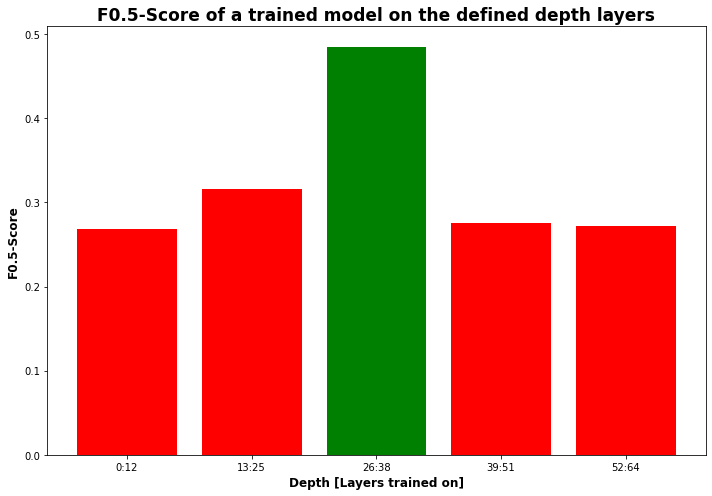

In [27]:
figure = plt.figure(figsize=(10, 7))
plt.bar(x=df.Depths.values, height=df['F0.5-Score'].values, color=['r', 'r', 'g', 'r', 'r'])
plt.ylabel('F0.5-Score', fontsize=12, fontweight='bold')
plt.xlabel('Depth [Layers trained on]', fontsize=12, fontweight='bold')
plt.title('F0.5-Score of a trained model on the defined depth layers', fontsize=17, fontweight='bold')
path_fig = f'{folder}/Figures/Ink_Depth_Analysis.png'
plt.tight_layout()
figure.patch.set_facecolor('white')
plt.savefig(path_fig)
plt.show()